In [7]:
%%capture
%run 1-setup.ipynb

In [8]:
from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from sklearn.preprocessing import MinMaxScaler

The first thing to do when doing clustering is to normalize or standardize the data.

The reason is that we want everything on the same scale in order to avoid scale differences to be included in the distance evaluation.

Here we chose to normalize with the minmax scaler.

In [9]:
# let's normalize the numerical features of the dataframe
for df in dataframes.values():
    df[numerics] = MinMaxScaler().fit_transform(df[numerics])

In [10]:
dataframes['modena']

,date,TG,TN,TX,HU,PP,QQ,RR,CO,NH3,NMVOC,NO2,NO,O3,PANS,PM10,PM2.5,SO2
365,2018-01-01,0.192517,0.187638,0.201774,0.766256,0.648770,0.169256,0.344585,0.492949,0.233042,0.477343,0.640063,0.259001,0.216620,0.247671,0.239727,0.336735,0.380032
366,2018-01-02,0.222201,0.188871,0.268293,0.591700,0.609814,0.144326,0.191057,0.397737,0.206395,0.398278,0.563908,0.306594,0.247134,0.156890,0.136759,0.206431,0.361481
367,2018-01-03,0.252868,0.212250,0.311900,0.548923,0.600643,0.125377,0.113998,0.347551,0.192213,0.386264,0.544158,0.352827,0.251987,0.100395,0.106618,0.153308,0.330189
368,2018-01-04,0.280890,0.246523,0.336974,0.589509,0.611009,0.111318,0.089192,0.329655,0.185605,0.415508,0.559859,0.394969,0.240968,0.072193,0.125209,0.154705,0.299526
369,2018-01-05,0.303738,0.283040,0.347514,0.674765,0.632537,0.101267,0.097055,0.333457,0.182913,0.465607,0.594436,0.430948,0.221817,0.066539,0.172788,0.191549,0.278662
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1453,2020-12-24,0.336694,0.367331,0.287927,0.667950,0.741734,0.112907,0.108763,0.713927,0.194515,0.573656,0.559628,0.394682,0.137470,0.054728,0.440178,0.521086,0.315722
1454,2020-12-25,0.305189,0.314037,0.267763,0.601664,0.683920,0.120993,0.148339,0.629428,0.191720,0.491804,0.500323,0.313146,0.170791,0.041486,0.348824,0.404015,0.337862
1455,2020-12-26,0.261910,0.247921,0.238796,0.552746,0.614793,0.115429,0.267995,0.526658,0.193753,0.401543,0.431343,0.226852,0.209456,0.039228,0.262202,0.298799,0.360342
1456,2020-12-27,0.207051,0.173779,0.199843,0.544026,0.536425,0.086610,0.514782,0.398306,0.196999,0.296400,0.346652,0.133477,0.253484,0.052051,0.187791,0.217266,0.369965


TimeSeriesKmeans requires a 3D array, so let's create it from all the datasets

Given the high dimensionality of the data, we decided to use only the POLLUTANTS as variables to do clustering. The choice was made by visualizing the data and realising that the first variables had almost always groups overlapping with each other. This means that those variables have low clustering power. This saves some computing time because we reduce the complexity of the problem.

In [11]:
provinces = dataframes.keys()

# Prepare input data
X = []

for province in provinces:
    group_data = dataframes[province][pollutants].values
    
    # Reshape to (n_samples, n_timestamps, n_features)
    group_data = np.expand_dims(group_data, axis=0)
    X.append(group_data)

# Stack the list of arrays to create a 3D array
X = np.vstack(X)

In [12]:
X

array([[[0.42088577, 0.21677411, 0.56268505, ..., 0.16157246,
         0.23270619, 0.34745213],
        [0.32377846, 0.18760626, 0.41702559, ..., 0.07699273,
         0.12922045, 0.28589056],
        [0.27349688, 0.17201297, 0.36687773, ..., 0.04760027,
         0.08445976, 0.24534256],
        ...,
        [0.36850263, 0.13569174, 0.29153346, ..., 0.16064321,
         0.17973271, 0.32781521],
        [0.2874391 , 0.16002409, 0.22455446, ..., 0.1232337 ,
         0.15492998, 0.35695471],
        [0.27066056, 0.18845035, 0.19022568, ..., 0.14816803,
         0.20611274, 0.38093433]],

       [[0.47339873, 0.12893106, 0.6734312 , ..., 0.18367298,
         0.28468433, 0.37634103],
        [0.35087543, 0.12658381, 0.47058073, ..., 0.07815563,
         0.13189561, 0.31463271],
        [0.28974992, 0.12895394, 0.39519512, ..., 0.04433644,
         0.06639617, 0.26768579],
        ...,
        [0.4604487 , 0.1671294 , 0.49556184, ..., 0.18636297,
         0.23512048, 0.34069666],
        [0.3

When applying KMeans, we have to specify the number of clusters. This implies that we have to find the optimal number among the possible ones.
To do this, we examine the inertia and the silhouette score. They are both measures of how well separated the clusters are, therefore they can be used as goodness of fit measures.

The lower the inertia, the more the series are grouped towards the cluster center.

The higher the silhouette, the more the series are close to the other ones in the same cluster and far from the ones in other clusters.

In [13]:
inertia = []
silhouette = []
K = list(range(2, 9))

for k in K:
    km = TimeSeriesKMeans(n_clusters=k, n_init=5, metric='dtw', random_state=0)
    
    labels = km.fit_predict(X)
    
    silhouette_avg = silhouette_score(X, labels, metric='dtw')
    
    inertia.append(km.inertia_)
    silhouette.append(silhouette_avg)

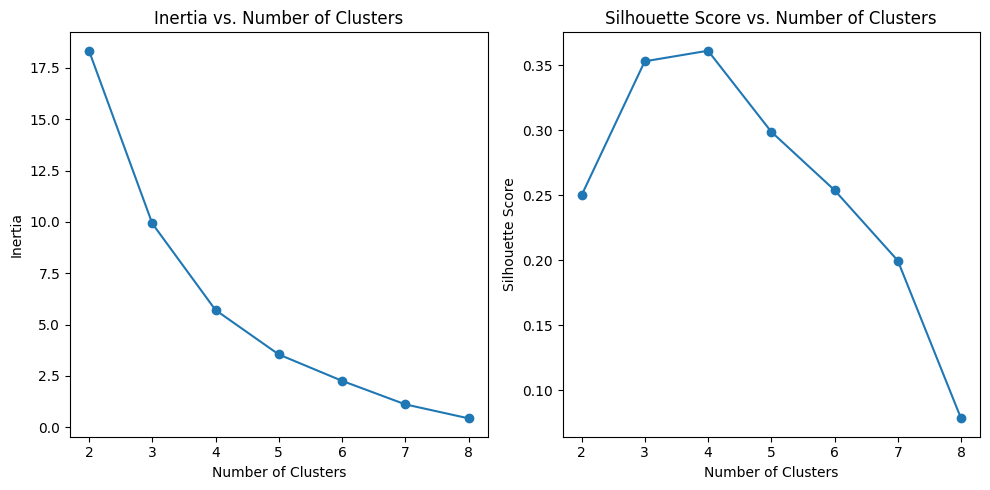

In [14]:
# Plotting the results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(K, inertia, marker='o')
plt.title('Inertia vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')

plt.subplot(1, 2, 2)
plt.plot(K, silhouette, marker='o')
plt.title('Silhouette Score vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()